In [1]:
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_core.tools import tool
import serpapi

In [3]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_KEY")

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [5]:
serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI")
}
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = serpapi.search({
        **serpapi_params,
        "q": query,
        "num": 1
    })
    results = search.data["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

/home/mgfos207/anaconda3/envs/LLM-Chatbot/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


TypeError: 'list' object is not callable

In [4]:
tools = [web_search]

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
# from langchain_community.chat_models import ChatOllama
from langchain_ollama import ChatOllama

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="mistral-nemo", temperature=0)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [7]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [8]:
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

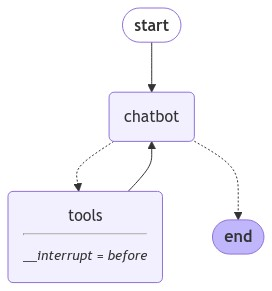

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from langchain_core.messages import BaseMessage

config = {"configurable": {"thread_id": "1"}}
# while True:
user_input = input("User: ")
if user_input.lower() in ["quit", "exit", "q"]:
    print("Goodbye!")
    # break

for event in graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

snapshot = graph.get_state(config)
print(snapshot.next, "The snapshot")
existing_message = snapshot.values["messages"][-1]
print(existing_message.tool_calls, "The tool calls")
for event in graph.stream(None, config, stream_mode="values"):
    if "messages" in event:
            event["messages"][-1].pretty_print()

================================ Human Message =================================

What jobs in Thailand are willing to pay for relocation from USA?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fad3df6c-48c7-4f93-a094-c27c9f74655b)
 Call ID: fad3df6c-48c7-4f93-a094-c27c9f74655b
  Args:
    query: What jobs in Thailand are willing to pay for relocation from USA?
('tools',) The snapshot
[{'name': 'tavily_search_results_json', 'args': {'query': 'What jobs in Thailand are willing to pay for relocation from USA?'}, 'id': 'fad3df6c-48c7-4f93-a094-c27c9f74655b', 'type': 'tool_call'}] The tool calls
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.glassdoor.com/Job/thailand-relocation-jobs-SRCH_IL.0,8_IN229_KO9,19.htm", "content": "Search Relocation jobs in Thailand with company ratings & salaries. 547 open jobs for Relocation in T